In [1]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.sampling import Sampling
from pymoo.operators.crossover.hux import HUX
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.optimize import minimize
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from utils import *
display_pca = False
N_NEIGHBOURS = 5
blank_row = {"Label": '---', 
		    "Num Features": '---', 
		    "Num Examples": '---', 
		    "Training Size": '---', 
		    "Minority Class": '---', 
			"Base - Test C0 Acc": '---', 
		    "Base - Test C1 Acc": '---', 
		    "Base - Test Acc": '---', 
			"Base - Val C0 Acc": '---', 
		    "Base - Val C1 Acc": '---', 
		    "Base - Val Acc": '---', 
		    "Optimized - Test C0 Acc": '---', 
		    "Optimized - Test C1 Acc": '---', 
		    "Optimized - Test Acc": '---', 
			"Num Examples for Test Best": '---', 
			"Optimized - Val C0 Acc": '---', 
		    "Optimized - Val C1 Acc": '---', 
		    "Optimized - Val Acc": '---', 
			"Num Examples for Val Best": '---', 
			"Baseline IR": '---', 
		    "Optimized IR": '---'}

all_headers = ['Label', 
               'Num Features', 
               'Num Examples', 
               'Training Size', 
               'Minority Class', 
               'Base - Test C0 Acc', 
               'Base - Test C1 Acc', 
               'Base - Test Acc', 
               'Base - Val C0 Acc', 
               'Base - Val C1 Acc', 
               'Base - Val Acc', 
               'Optimized - Test C0 Acc', 
               'Optimized - Test C1 Acc', 
               'Optimized - Test Acc', 
               'Num Examples for Test Best', 
               'Optimized - Val C0 Acc', 
               'Optimized - Val C1 Acc', 
               'Optimized - Val Acc', 
               'Num Examples for Val Best', 
               'Baseline IR', 
               'Optimized IR']

# Overall function definitions

In [2]:
class BiasedBinarySampling(Sampling):
	def __init__(self, labels, major_prob, minor_prob):
		
		self.labels = labels
		counts = pd.DataFrame(labels).value_counts()
		if counts[0] > counts[1]:
			self.c0_thresh = major_prob
			self.c1_thresh = minor_prob
		else:
			self.c0_thresh = minor_prob
			self.c1_thresh = major_prob

		super().__init__()

	def _do(self, problem, n_samples, **kwargs):

		rands = np.random.random((n_samples, problem.n_var))
		init_pops = np.zeros((n_samples, problem.n_var), dtype=bool)

		for idx, label in enumerate(self.labels):
			if label == 0:
				init_pops[:, idx] = (rands[:, idx] < self.c0_thresh).astype(bool)
			if label == 1:
				init_pops[:, idx] = (rands[:, idx] < self.c1_thresh).astype(bool)


		return init_pops
	
class InstanceSelectionProblem_2_Obj(Problem):
	def __init__(self, X_train, y_train, X_val, y_val):
		
		self.X_train = X_train
		self.y_train = y_train

		self.X_val = X_val
		self.y_val = y_val

		self.training_data = X_train
		self.n_instances = X_train.shape[0]
		
		super().__init__(
			n_var=self.n_instances,
			n_obj=2,               
			n_constr=0,            
			xl=0,                  
			xu=1,                  
			type_var=np.bool_,     
		)

	def _evaluate(self, x, out, *args, **kwargs):
		# Calculate number of examples in each instance
		f1 = np.sum(x, axis=1)

		# Calculate inverse accuracy
		f2 = Parallel(n_jobs=-1)(delayed(self.train_model)(instance) for instance in x)

		out["F"] = np.column_stack([f1, f2])

	def train_model(self, instance):
		x_train_filtered, y_train_filtered = self.X_train[instance], self.y_train[instance]
		
		num_included_instances = x_train_filtered.shape[0]

		if num_included_instances >= N_NEIGHBOURS:
			optimization_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
			optimization_knn.fit(x_train_filtered, y_train_filtered)

			y_pred = optimization_knn.predict(self.X_val)
			acc = accuracy_score(self.y_val, y_pred)
			return 1-acc
		else:
			return 1

class InstanceSelectionProblem_3_Obj(Problem):
	def __init__(self, X_train, y_train, X_val, y_val):
		
		self.X_train = X_train
		self.y_train = y_train

		self.X_val = X_val
		self.y_val = y_val

		self.training_data = X_train
		self.n_instances = X_train.shape[0]
		
		super().__init__(
			n_var=self.n_instances,
			n_obj=3,               
			n_constr=0,            
			xl=0,                  
			xu=1,                  
			type_var=np.bool_,     
		)

	def _evaluate(self, x, out, *args, **kwargs):
		# Calculate number of examples in each instance
		f1 = np.sum(x, axis=1)

		# Calculate inverse accuracy
		f2 = Parallel(n_jobs=-1)(delayed(self.train_model)(instance) for instance in x)

		f3 = Parallel(n_jobs=-1)(delayed(self.calculate_instance_IR)(instance) for instance in x)
		
		out["F"] = np.column_stack([f1, f2, f3])

	def calculate_instance_IR(self, instance):
		num_1_class = np.sum(self.y_train[instance])
		num_0_class = self.n_instances - num_1_class
		IR = max(num_0_class, num_1_class) / min(num_0_class, num_1_class)
		return IR

	def train_model(self, instance):
		x_train_filtered, y_train_filtered = self.X_train[instance], self.y_train[instance]
		
		num_included_instances = x_train_filtered.shape[0]

		if num_included_instances >= N_NEIGHBOURS:
			optimization_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
			optimization_knn.fit(x_train_filtered, y_train_filtered)

			y_pred = optimization_knn.predict(self.X_val)
			acc = accuracy_score(self.y_val, y_pred)
			return 1-acc
		else:
			return 1

class InstanceSelectionProblem_2_Obj_MinMaxAcc(Problem):
	def __init__(self, X_train, y_train, X_val, y_val):
		
		self.X_train = X_train
		self.y_train = y_train

		self.X_val = X_val
		self.y_val = y_val

		self.training_data = X_train
		self.n_instances = X_train.shape[0]
		
		super().__init__(
			n_var=self.n_instances,
			n_obj=2,               
			n_constr=0,            
			xl=0,                  
			xu=1,                  
			type_var=np.bool_,     
		)

	def _evaluate(self, x, out, *args, **kwargs):
		objectives = Parallel(n_jobs=-1)(delayed(self.train_model)(instance) for instance in x)
		f1 = [obj[0] for obj in objectives] # Class 0 error
		f2 = [obj[1] for obj in objectives] # Class 1 error
		out["F"] = np.column_stack([f1, f2])

	def train_model(self, instance):
		print(f">>>> {instance}")
		x_train_filtered, y_train_filtered = self.X_train[instance], self.y_train[instance]
		num_included_instances = x_train_filtered.shape[0]

		if num_included_instances >= N_NEIGHBOURS:
			optimization_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
			optimization_knn.fit(x_train_filtered, y_train_filtered)

			class_1_indices = np.where(self.y_val==1)
			class_0_indices = np.where(self.y_val==0)

			class_1_x_val = self.X_val[class_1_indices]
			class_0_x_val = self.X_val[class_0_indices]

			class_1_y_val = self.y_val[class_1_indices]
			class_0_y_val = self.y_val[class_0_indices]
			
			class_1_pred = optimization_knn.predict(class_1_x_val)
			class_1_acc = accuracy_score(class_1_y_val, class_1_pred)

			class_0_pred = optimization_knn.predict(class_0_x_val)
			class_0_acc = accuracy_score(class_0_y_val, class_0_pred)

			return (1-class_0_acc, 1-class_1_acc)
		else:
			return (1, 1)
				
def parse_dataset(path, name, over_sample=False):
	try:
		df = pd.read_csv(path, delimiter=', ')
		X = df.drop(columns='Class')
		y = df['Class']
	except KeyError:
		df = pd.read_csv(path, delimiter=',')
		X = df.drop(columns='Class')
		y = df['Class']

	# Generate train, validation, and test sets
	label_encoder = LabelEncoder()
	y_encoded = label_encoder.fit_transform(y)
	X_train, X_val, X_test, y_train, y_val, y_test = split_and_scale_datasets(X, y_encoded)

	if over_sample:
		class_0_count, class_1_count, IR = set_summary(y_train, "y_train", False)
		if class_0_count > class_1_count:
			minority_class_indicies = np.where(y_train == 1)
		else:
			minority_class_indicies = np.where(y_train == 0)

		X_train = np.concatenate((X_train, X_train[minority_class_indicies]), axis=0)
		y_train = np.concatenate((y_train, y_train[minority_class_indicies]), axis=0)

	return [X, y, X_train, X_val, X_test, y_train, y_val, y_test, name]

def class_based_accuracy(model, x, y):
	class_1_indices = np.where(y==1)
	class_0_indices = np.where(y==0)

	class_1_x = x[class_1_indices]
	class_0_x = x[class_0_indices]

	class_1_y = y[class_1_indices]
	class_0_y = y[class_0_indices]
	
	class_1_pred = model.predict(class_1_x)
	class_1_acc = accuracy_score(class_1_y, class_1_pred)

	class_0_pred = model.predict(class_0_x)
	class_0_acc = accuracy_score(class_0_y, class_0_pred)

	overall_prediction = model.predict(x)
	overall_accuracy = accuracy_score(y, overall_prediction)

	return class_0_acc, class_1_acc, overall_accuracy

# Defining and packaging datasets

In [3]:
datasets = []
for folder in os.listdir('Datasets'):
	datasets.append(parse_dataset(os.path.join('Datasets', folder, f"{folder}.csv"), folder, over_sample=True))

C:\Users\RjKim\AppData\Local\Temp\ipykernel_21236\169272633.py:184: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, delimiter=', ')
C:\Users\RjKim\AppData\Local\Temp\ipykernel_21236\169272633.py:184: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, delimiter=', ')
C:\Users\RjKim\AppData\Local\Temp\ipykernel_21236\169272633.py:184: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python

In [ ]:
def execute_Iter1(X, y, X_train, X_val, X_test, y_train, y_val, y_test, name, problem_defn, sampler):
	print(f"Executing {problem_defn} on {name}...")
	
	num_examples, num_features = set_summary(X, 'x', print_res=False)
	class_0_count, class_1_count, baseline_IR = set_summary(y, 'y', print_res=False)
	minority_class = 0 if min(class_0_count, class_1_count) == class_0_count else 1

	# Determine baseline accuracy of classifier on all examples
	baseline_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
	baseline_knn.fit(X_train, y_train)
	class_0_baseline_testAcc, class_1_baseline_testAcc, baseline_testAcc = class_based_accuracy(baseline_knn, X_test, y_test)
	class_0_baseline_valAcc, class_1_baseline_valAcc, baseline_valAcc = class_based_accuracy(baseline_knn, X_val, y_val)
	
	# Execute the optimization algorithm
	algorithm = NSGA2(
		pop_size=100, 
		sampling=sampler, 
		crossover=HUX(), 
		mutation=BitflipMutation(), 
		eliminate_duplicates=True
	)
	problem = problem_defn(X_train, y_train, X_val, y_val)
	res = minimize(problem, algorithm, ('n_gen', 100), verbose=False, seed=42)

	# Calculate the best instance and extract its values
	fronts = NonDominatedSorting().do(res.F, only_non_dominated_front=True)
	unique_F, unique_indices = np.unique(res.F[fronts], axis=0, return_index=True)
	best_instance_idx = np.argmin(unique_F[:,1])
	num_instance_in_best_solution = unique_F[best_instance_idx, 0]
	best_instance = res.X[unique_indices[best_instance_idx]]
	
	# Calculate the optimized accuracy of the best instance
	x_train_filtered, y_train_filtered = X_train[best_instance], y_train[best_instance]
	_, _, optimized_IR = set_summary(y_train_filtered, 'y', print_res=False)

	# Calculate the optimized accuracy of the best instance on test set and validation set
	optimized_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
	optimized_knn.fit(x_train_filtered, y_train_filtered)
	class_0_optimized_testAcc, class_1_optimized_testAcc, optimized_testAcc = class_based_accuracy(optimized_knn, X_test, y_test)
	class_0_optimized_valAcc, class_1_optimized_valAcc, optimized_valAcc = class_based_accuracy(optimized_knn, X_val, y_val)
	
	test_results = []
	best_test_instance = [-1, 1]
	for instance in res.X[unique_indices]:
		x_filtered, y_filtered = X_train[instance], y_train[instance]
		if x_filtered.shape[0] < N_NEIGHBOURS: error = 1
		else:
			knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
			knn.fit(x_filtered, y_filtered)
			y_pred = knn.predict(X_test)
			error = 1 - accuracy_score(y_test, y_pred)
		
		if best_test_instance[1] > error:
			best_test_instance = [x_filtered.shape[0], error]

			
		test_results.append([x_filtered.shape[0], error])
	
	# fronts = NonDominatedSorting().do(test_results, only_non_dominated_front=True)

	x2, y2 = [row[0] for row in test_results], [row[1] for row in test_results]
	x1, y1 = [row[0] for row in unique_F], [row[1] for row in unique_F]
	plt.ylim((0, 1))
	plt.title(name)
	plt.ylabel("f2 *")
	plt.xlabel("f1")
	plt.scatter(x1, y1, c='b')
	plt.scatter(x2, y2, c='r')
	plt.show()

	return {"Label": name, 
		    "Num Features": num_features, 
		    "Num Examples": num_examples,
		    "Training Size": X_train.shape[0],
		    "Minority Class": minority_class,
		    
			"Base - Test C0 Acc": round(class_0_baseline_testAcc*100,2), 
		    "Base - Test C1 Acc": round(class_1_baseline_testAcc*100,2), 
		    "Base - Test Acc": round(baseline_testAcc*100,2), 

			"Base - Val C0 Acc": round(class_0_baseline_valAcc*100,2), 
		    "Base - Val C1 Acc": round(class_1_baseline_valAcc*100,2), 
		    "Base - Val Acc": round(baseline_valAcc*100,2), 

		    "Optimized - Test C0 Acc": round(class_0_optimized_testAcc*100,2), 
		    "Optimized - Test C1 Acc": round(class_1_optimized_testAcc*100,2), 
		    "Optimized - Test Acc": round(optimized_testAcc*100,2), 
			"Num Examples for Test Best": best_test_instance[0],
			
			"Optimized - Val C0 Acc": round(class_0_optimized_valAcc*100,2), 
		    "Optimized - Val C1 Acc": round(class_1_optimized_valAcc*100,2), 
		    "Optimized - Val Acc": round(optimized_valAcc*100,2), 
			"Num Examples for Val Best": num_instance_in_best_solution,
		    
			"Baseline IR": baseline_IR,
		    "Optimized IR": optimized_IR}

In [5]:
def execute_class_sensitive_optimization(X, y, X_train, X_val, X_test, y_train, y_val, y_test, name, problem_defn, sampler):
	print(f"Executing {problem_defn} on {name}...")
	
	num_examples, num_features = set_summary(X, 'x', print_res=False)
	class_0_count, class_1_count, baseline_IR = set_summary(y, 'y', print_res=False)
	minority_class = 0 if min(class_0_count, class_1_count) == class_0_count else 1

	# Determine baseline accuracy of classifier on all examples
	baseline_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
	baseline_knn.fit(X_train, y_train)
	class_0_baseline_testAcc, class_1_baseline_testAcc, baseline_testAcc = class_based_accuracy(baseline_knn, X_test, y_test)
	class_0_baseline_valAcc, class_1_baseline_valAcc, baseline_valAcc = class_based_accuracy(baseline_knn, X_val, y_val)

	# Execute the optimization algorithm
	problem = problem_defn(X_train, y_train, X_val, y_val)
	algorithm = NSGA2(
		pop_size=100, 
		sampling=sampler, 
		crossover=HUX(), 
		mutation=BitflipMutation(), 
		eliminate_duplicates=True)
	
	res = minimize(problem, algorithm, ('n_gen', 100), verbose=False, seed=42)

	# Calculate the first rank pareto front
	fronts = NonDominatedSorting().do(res.F, only_non_dominated_front=True)
	unique_F, unique_indices = np.unique(res.F[fronts], axis=0, return_index=True)

	# Extract best instances for minority class
	if minority_class == 0:
		best_instance_idx = np.argmin(unique_F[0,:])
	else:
		best_instance_idx = np.argmin(unique_F[:,0])

	best_instance = res.X[unique_indices[best_instance_idx]]
	x_train_filtered, y_train_filtered = X_train[best_instance], y_train[best_instance]
	num_instance_in_best_solution = y_train_filtered.shape[0]
	_, _, optimized_IR = set_summary(y_train_filtered, 'y', print_res=False)
	
	# Calculate the optimized accuracy of the best instance on test set and validation set
	optimized_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
	optimized_knn.fit(x_train_filtered, y_train_filtered)
	class_0_optimized_testAcc, class_1_optimized_testAcc, optimized_testAcc = class_based_accuracy(optimized_knn, X_test, y_test)
	class_0_optimized_valAcc, class_1_optimized_valAcc, optimized_valAcc = class_based_accuracy(optimized_knn, X_val, y_val)

	test_pareto_front = []
	num_examples_in_best_instance_on_test = -1
	best_error_instance_on_test = 1
	for instance in res.X[unique_indices]:
		x_filtered, y_filtered = X_train[instance], y_train[instance]
		if x_filtered.shape[0] < N_NEIGHBOURS: test_pareto_front.append([1, 1])
		else:
			knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
			knn.fit(x_filtered, y_filtered)
			
			class_1_indices = np.where(y_test==1)
			class_0_indices = np.where(y_test==0)

			class_1_x_val = X_test[class_1_indices]
			class_0_x_val = X_test[class_0_indices]
			class_1_y_val = y_test[class_1_indices]
			class_0_y_val = y_test[class_0_indices]
			
			class_1_pred = knn.predict(class_1_x_val)
			class_1_acc = accuracy_score(class_1_y_val, class_1_pred)

			class_0_pred = knn.predict(class_0_x_val)
			class_0_acc = accuracy_score(class_0_y_val, class_0_pred)

			if minority_class == 0:
				if (1-class_0_acc) < best_error_instance_on_test:
					num_examples_in_best_instance_on_test = x_filtered.shape[0]
					best_error_instance_on_test = (1-class_0_acc)
			else:
				if (1-class_1_acc) < best_error_instance_on_test:
					num_examples_in_best_instance_on_test = x_filtered.shape[0]
					best_error_instance_on_test = (1-class_1_acc)

			test_pareto_front.append([1-class_0_acc, 1-class_1_acc])

	x1, y1 = [row[0] for row in unique_F], [row[1] for row in unique_F]
	x2, y2 = [row[0] for row in test_pareto_front], [row[1] for row in test_pareto_front]
	plt.ylim((0, 1))
	plt.xlim((0, 1))
	plt.title(name)
	plt.ylabel(f"f1 {'*' if minority_class == 0 else ''}")
	plt.xlabel(f"f2 {'*' if minority_class == 1 else ''}")
	plt.scatter(x1, y1, c='b')
	plt.scatter(x2, y2, c='r')
	plt.show()

	return {"Label": name, 
		    "Num Features": num_features, 
		    "Num Examples": num_examples,
		    "Training Size": X_train.shape[0],
		    "Minority Class": minority_class,
		    
			"Base - Test C0 Acc": round(class_0_baseline_testAcc*100,2), 
		    "Base - Test C1 Acc": round(class_1_baseline_testAcc*100,2), 
		    "Base - Test Acc": round(baseline_testAcc*100,2), 

			"Base - Val C0 Acc": round(class_0_baseline_valAcc*100,2), 
		    "Base - Val C1 Acc": round(class_1_baseline_valAcc*100,2), 
		    "Base - Val Acc": round(baseline_valAcc*100,2), 

		    "Optimized - Test C0 Acc": round(class_0_optimized_testAcc*100,2), 
		    "Optimized - Test C1 Acc": round(class_1_optimized_testAcc*100,2), 
		    "Optimized - Test Acc": round(optimized_testAcc*100,2), 
			"Num Examples for Test Best": num_examples_in_best_instance_on_test,
			
			"Optimized - Val C0 Acc": round(class_0_optimized_valAcc*100,2), 
		    "Optimized - Val C1 Acc": round(class_1_optimized_valAcc*100,2), 
		    "Optimized - Val Acc": round(optimized_valAcc*100,2), 
			"Num Examples for Val Best": num_instance_in_best_solution,
		    
			"Baseline IR": baseline_IR,
		    "Optimized IR": optimized_IR}

In [1]:
def report_table_1(results):
	display_columns = ['Label', 'Num Features', 'Num Examples', 'Training Size', 'Minority Class', '-----', 'Baseline IR', 'Optimized IR']
	data = []
	for result in results:
		data.append([])
		for idx, key in enumerate(display_columns):
			if key in result:
				data[-1].append(result[key])
			else:
				data[-1].append("--")
							
	return pd.DataFrame(data, columns=display_columns)

def report_table_2(results):
	display_columns = ['Label', 
					'Base - Test Acc', 
					'Base - Val Acc',
					'Base - Test C0 Acc', 
					'Base - Test C1 Acc', 
					'-----',
					
					'Optimized - Test Acc', 
					'Optimized - Test C0 Acc', 
					'Optimized - Test C1 Acc', 
					'Num Examples for Test Best', 
					'-----',
					
					'Optimized - Val Acc', 
					'Optimized - Val C0 Acc', 
					'Optimized - Val C1 Acc', 
					'Num Examples for Val Best']
	data = []
	for result in results:
		data.append([])
		for idx, key in enumerate(display_columns):
			if key in result:
				data[-1].append(result[key])
			else:
				data[-1].append("-----")
							
	return pd.DataFrame(data, columns=display_columns)

# Random and biased initial population for objectices --> Error and number of examples

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on rand-2Obj-glass1...


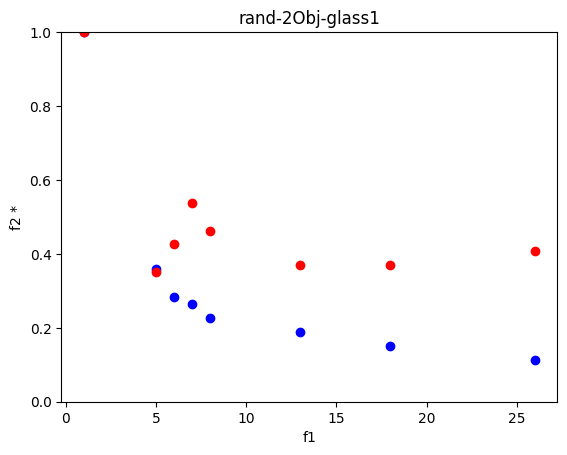

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on bias-2Obj-glass1...


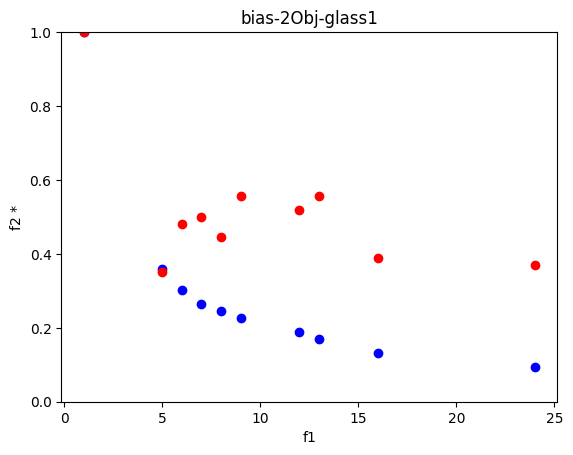

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on rand-2Obj-page-blocks0...


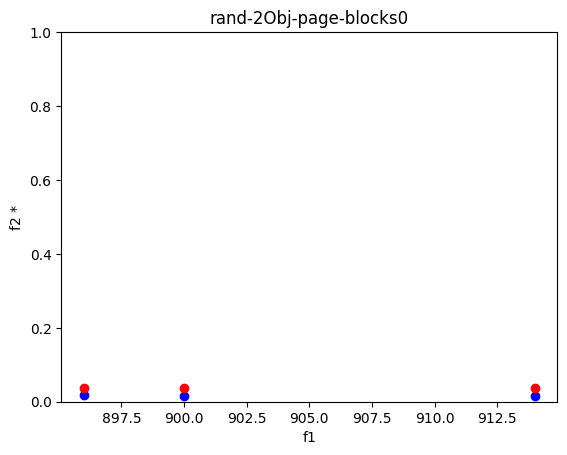

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on bias-2Obj-page-blocks0...


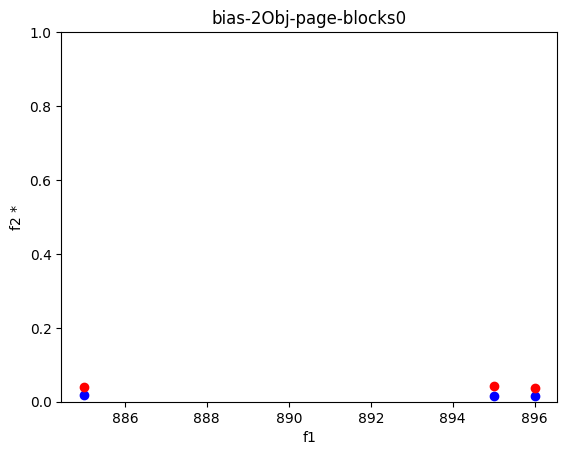

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on rand-2Obj-pima...


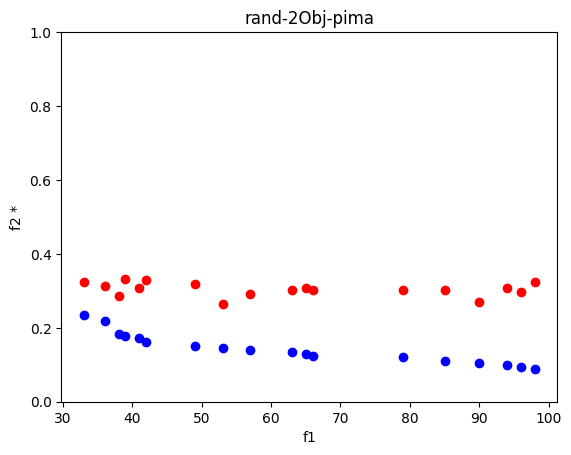

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on bias-2Obj-pima...


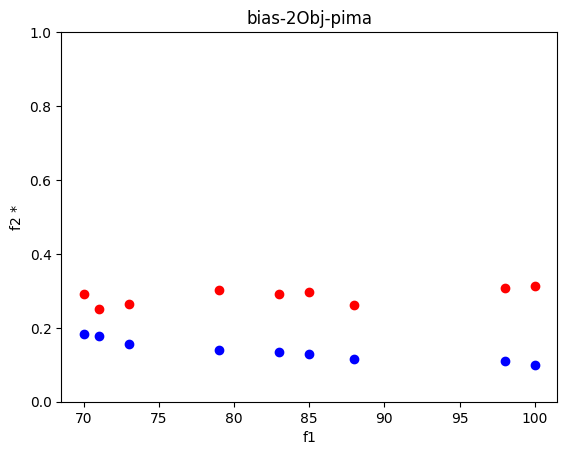

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on rand-2Obj-segment0...


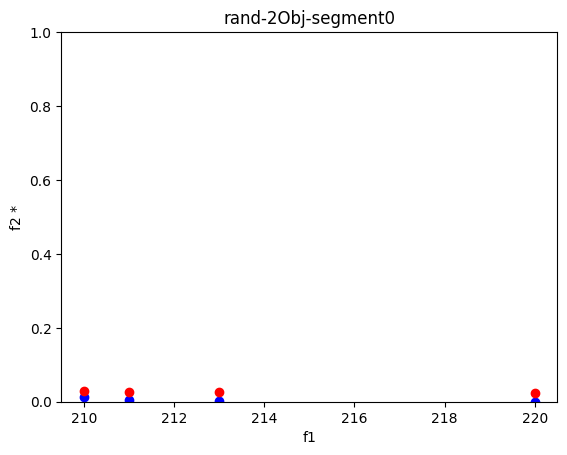

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on bias-2Obj-segment0...


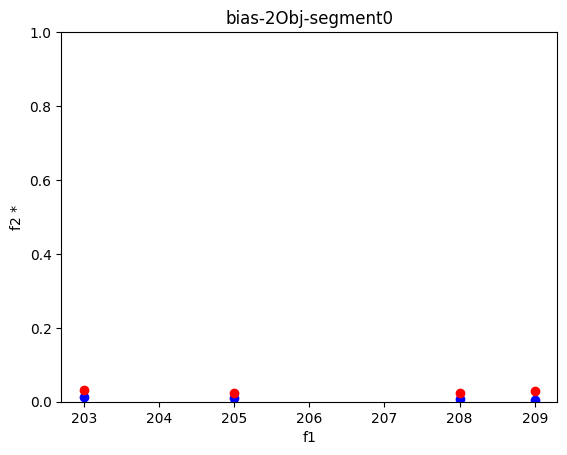

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on rand-2Obj-vehicle0...


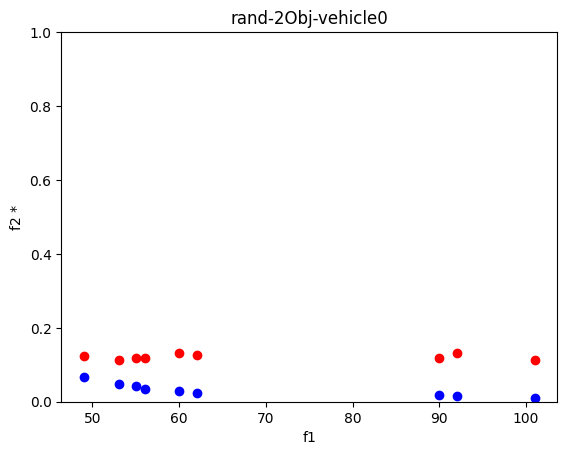

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on bias-2Obj-vehicle0...


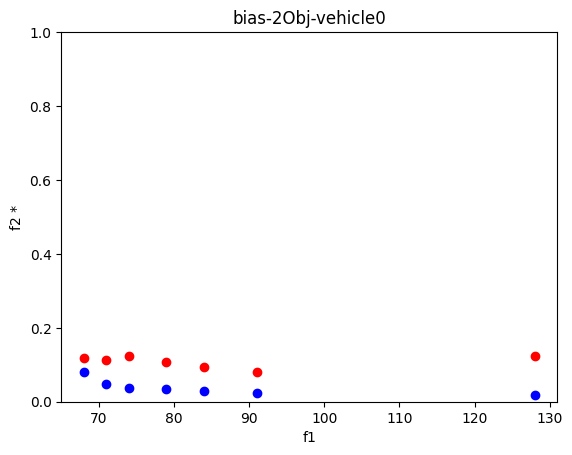

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on rand-2Obj-yeast1...


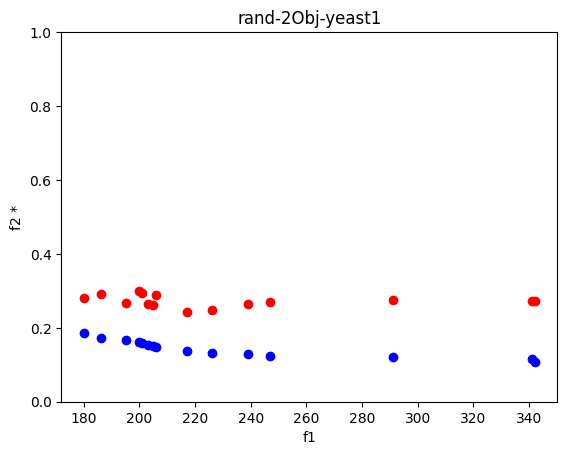

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on bias-2Obj-yeast1...


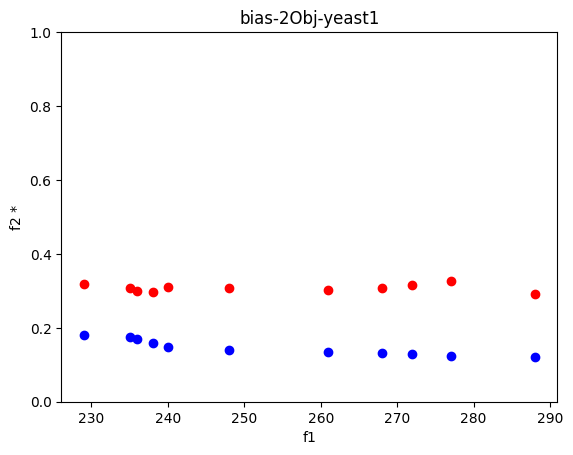

In [7]:
results = []
for X, y, X_train, X_val, X_test, y_train, y_val, y_test, name in datasets:
	result = execute_Iter1(
		X, y, X_train, X_val, X_test, y_train, y_val, y_test, f"rand-2Obj-{name}", 
		InstanceSelectionProblem_2_Obj, 
		BinaryRandomSampling()
	)
	results.append(result)

	result = execute_Iter1(
		X, y, X_train, X_val, X_test, y_train, y_val, y_test, f"bias-2Obj-{name}", 
		InstanceSelectionProblem_2_Obj, 
		BiasedBinarySampling(y_train, 0.5, 0.7)
	)
	results.append(result)
	
	results.append(blank_row)


In [10]:
report_table_1(results)

,Label,Num Features,Num Examples,Training Size,Minority Class,-----,Baseline IR,Optimized IR
0,rand-2Obj-glass1,9,214,145,1,--,1.8158,1.1667
1,bias-2Obj-glass1,9,214,145,1,--,1.8158,1.4
2,---,---,---,---,---,--,---,---
3,rand-2Obj-page-blocks0,10,5472,3016,1,--,8.7889,4.345
4,bias-2Obj-page-blocks0,10,5472,3016,1,--,8.7889,2.6275
5,---,---,---,---,---,--,---,---
6,rand-2Obj-pima,8,768,518,1,--,1.8657,1.3902
7,bias-2Obj-pima,8,768,518,1,--,1.8657,1.6316
8,---,---,---,---,---,--,---,---
9,rand-2Obj-segment0,19,2308,1319,1,--,6.0152,2.6667


In [11]:
report_table_2(results)

,Label,Base - Test Acc,Base - Test C0 Acc,Base - Test C1 Acc,-----,Optimized - Test Acc,Optimized - Test C0 Acc,Optimized - Test C1 Acc,Num Examples for Test Best,-----,Optimized - Val Acc,Optimized - Val C0 Acc,Optimized - Val C1 Acc,Num Examples for Val Best
0,rand-2Obj-glass1,70.37,71.43,68.42,-----,59.26,65.71,47.37,5,-----,88.68,85.29,94.74,26.0
1,bias-2Obj-glass1,70.37,71.43,68.42,-----,62.96,68.57,52.63,5,-----,90.57,88.24,94.74,24.0
2,---,---,---,---,-----,---,---,---,---,-----,---,---,---,---
3,rand-2Obj-page-blocks0,96.93,98.05,87.05,-----,96.42,97.56,86.33,900,-----,98.54,99.43,90.71,914.0
4,bias-2Obj-page-blocks0,96.93,98.05,87.05,-----,96.35,97.56,85.61,896,-----,98.39,99.1,92.14,896.0
5,---,---,---,---,-----,---,---,---,---,-----,---,---,---,---
6,rand-2Obj-pima,69.79,73.6,62.69,-----,67.71,75.2,53.73,53,-----,91.15,95.2,83.58,98.0
7,bias-2Obj-pima,69.79,73.6,62.69,-----,68.75,74.4,58.21,71,-----,90.1,92.8,85.07,100.0
8,---,---,---,---,-----,---,---,---,---,-----,---,---,---,---
9,rand-2Obj-segment0,98.61,98.59,98.78,-----,97.75,97.37,100.0,220,-----,100.0,100.0,100.0,220.0


# Random and biased initial population for objectives --> Error, number of examples, and imbalance ratio

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on rand-3Obj-glass1...


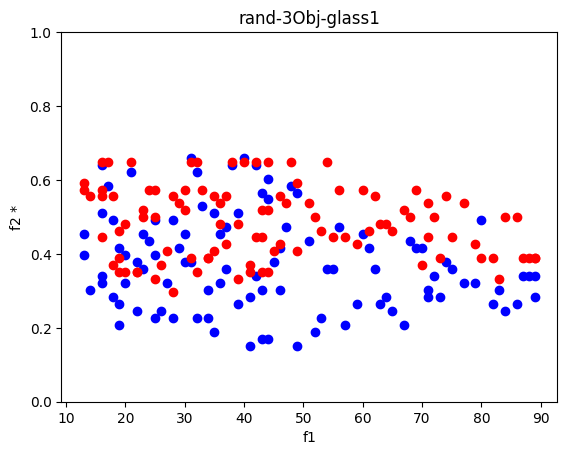

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on bias-3Obj-glass1...


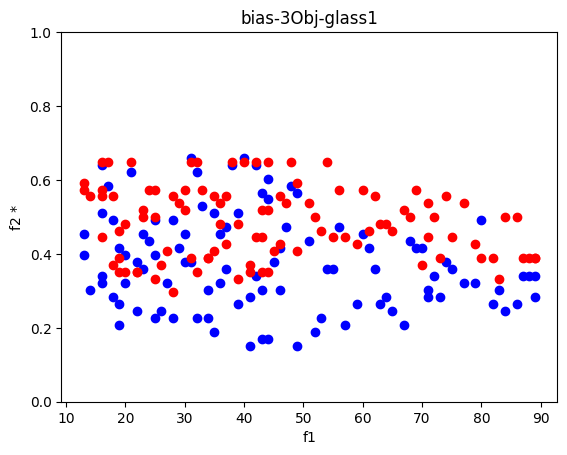

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on rand-3Obj-page-blocks0...


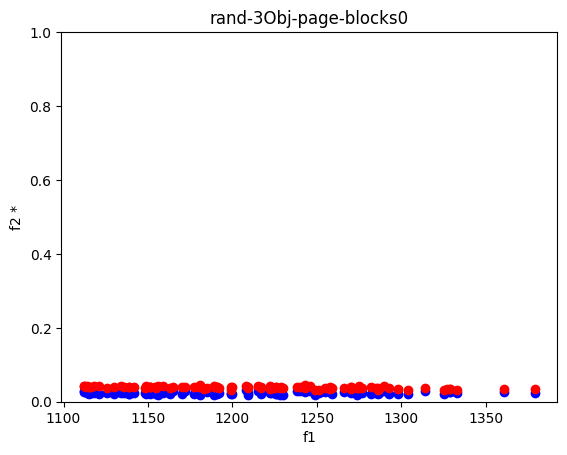

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on bias-3Obj-page-blocks0...


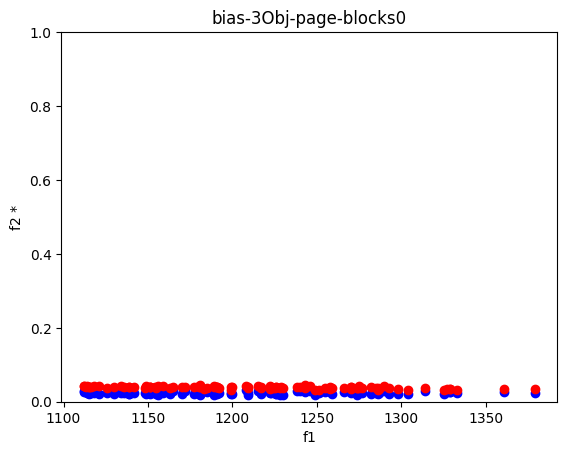

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on rand-3Obj-pima...


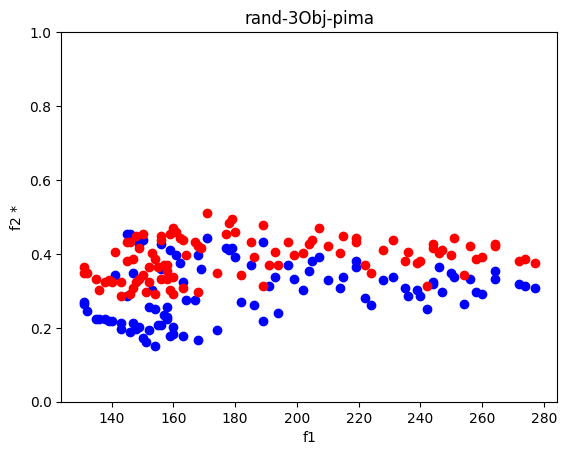

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on bias-3Obj-pima...


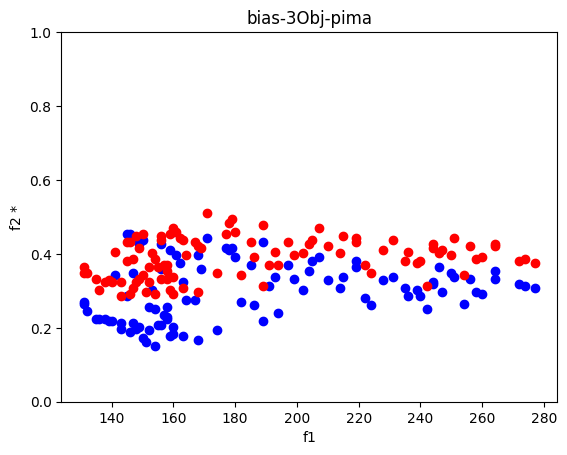

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on rand-3Obj-segment0...


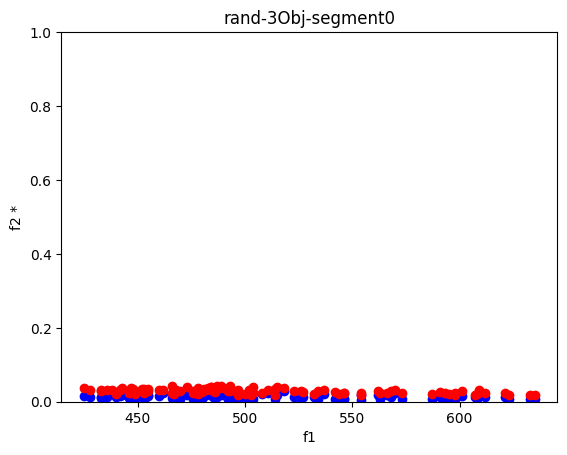

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on bias-3Obj-segment0...


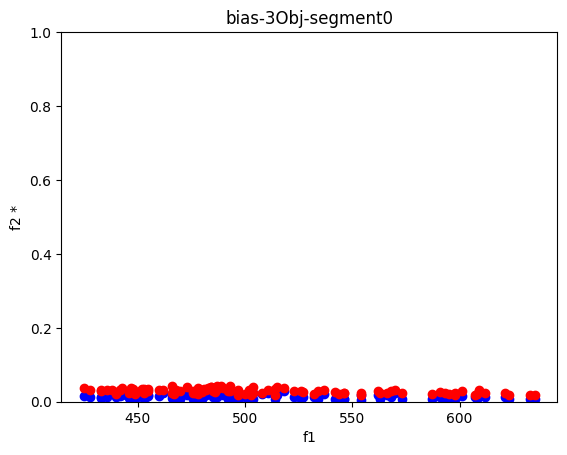

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on rand-3Obj-vehicle0...


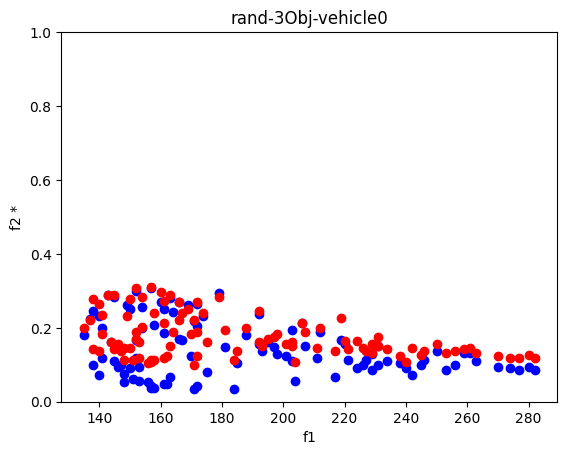

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on bias-3Obj-vehicle0...


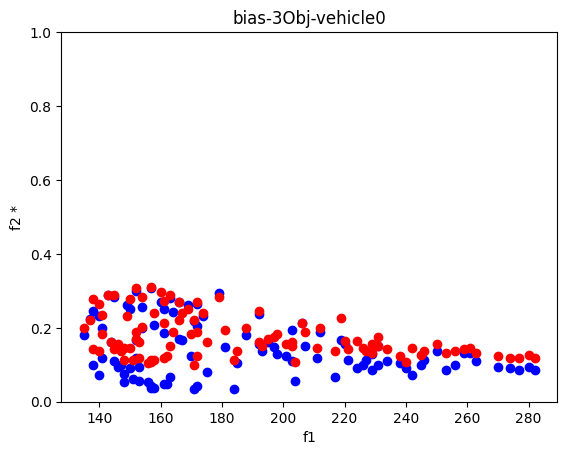

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on rand-3Obj-yeast1...


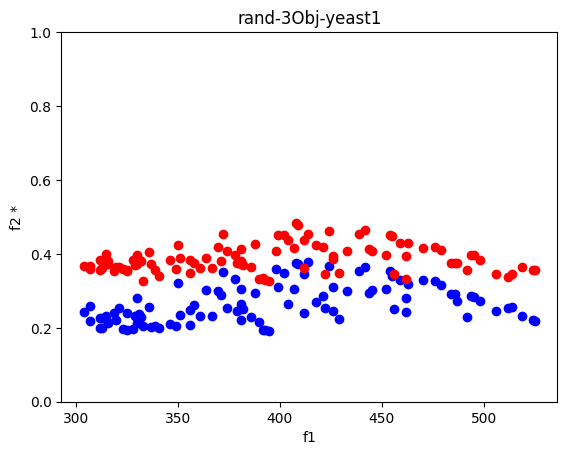

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on bias-3Obj-yeast1...


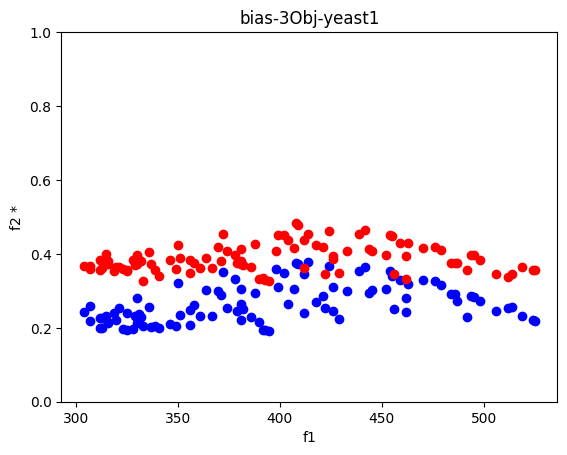

In [12]:
results = []
for X, y, X_train, X_val, X_test, y_train, y_val, y_test, name in datasets:

	result = execute_Iter1(
		X, y, X_train, X_val, X_test, y_train, y_val, y_test, f"rand-3Obj-{name}", 
		InstanceSelectionProblem_3_Obj, 
		BinaryRandomSampling()
	)
	results.append(result)

	result = execute_Iter1(
		X, y, X_train, X_val, X_test, y_train, y_val, y_test, f"bias-3Obj-{name}", 
		InstanceSelectionProblem_3_Obj, 
		BinaryRandomSampling()
	)
	results.append(result)
	results.append(blank_row)


In [13]:
report_table_1(results)

,Label,Num Features,Num Examples,Training Size,Minority Class,-----,Baseline IR,Optimized IR
0,rand-3Obj-glass1,9,214,145,1,--,1.8158,1.7333
1,bias-3Obj-glass1,9,214,145,1,--,1.8158,1.7333
2,---,---,---,---,---,--,---,---
3,rand-3Obj-page-blocks0,10,5472,3016,1,--,8.7889,2.8152
4,bias-3Obj-page-blocks0,10,5472,3016,1,--,8.7889,2.8152
5,---,---,---,---,---,--,---,---
6,rand-3Obj-pima,8,768,518,1,--,1.8657,1.8
7,bias-3Obj-pima,8,768,518,1,--,1.8657,1.8
8,---,---,---,---,---,--,---,---
9,rand-3Obj-segment0,19,2308,1319,1,--,6.0152,1.7459


In [14]:
report_table_2(results)

,Label,Base - Test Acc,Base - Test C0 Acc,Base - Test C1 Acc,-----,Optimized - Test Acc,Optimized - Test C0 Acc,Optimized - Test C1 Acc,Num Examples for Test Best,-----,Optimized - Val Acc,Optimized - Val C0 Acc,Optimized - Val C1 Acc,Num Examples for Val Best
0,rand-3Obj-glass1,70.37,71.43,68.42,-----,62.96,51.43,84.21,28,-----,84.91,79.41,94.74,41.0
1,bias-3Obj-glass1,70.37,71.43,68.42,-----,62.96,51.43,84.21,28,-----,84.91,79.41,94.74,41.0
2,---,---,---,---,-----,---,---,---,---,-----,---,---,---,---
3,rand-3Obj-page-blocks0,96.93,98.05,87.05,-----,95.76,97.07,84.17,1325,-----,98.1,98.86,91.43,1156.0
4,bias-3Obj-page-blocks0,96.93,98.05,87.05,-----,95.76,97.07,84.17,1325,-----,98.1,98.86,91.43,1156.0
5,---,---,---,---,-----,---,---,---,---,-----,---,---,---,---
6,rand-3Obj-pima,69.79,73.6,62.69,-----,70.83,67.2,77.61,143,-----,84.9,82.4,89.55,154.0
7,bias-3Obj-pima,69.79,73.6,62.69,-----,70.83,67.2,77.61,143,-----,84.9,82.4,89.55,154.0
8,---,---,---,---,-----,---,---,---,---,-----,---,---,---,---
9,rand-3Obj-segment0,98.61,98.59,98.78,-----,98.27,98.18,98.78,497,-----,99.48,99.39,100.0,497.0


# Random and biased initial population for objectives --> class 0 error and class 1 error

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMaxAcc'> on Rand-classSensglass1...


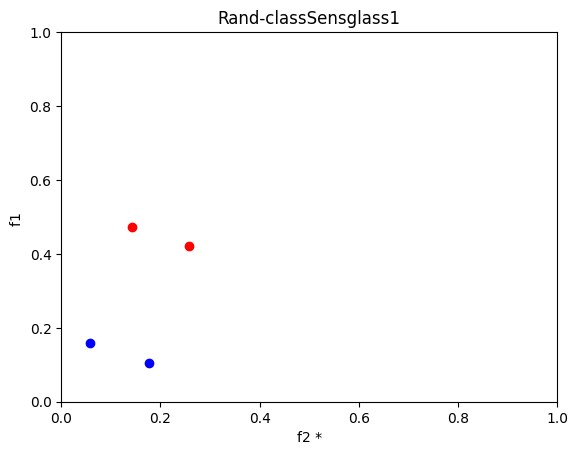

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMaxAcc'> on Bias-classSens-glass1...


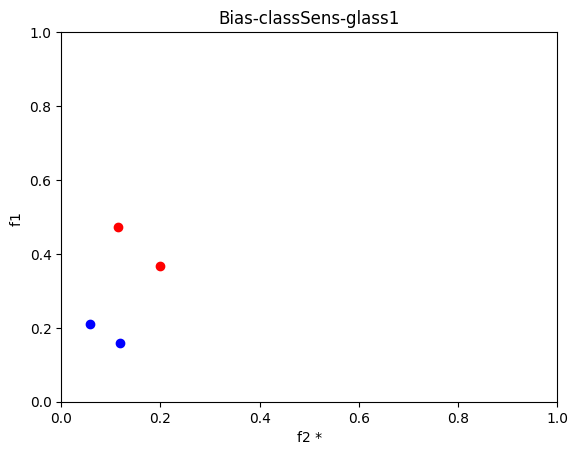

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMaxAcc'> on Rand-classSenspage-blocks0...


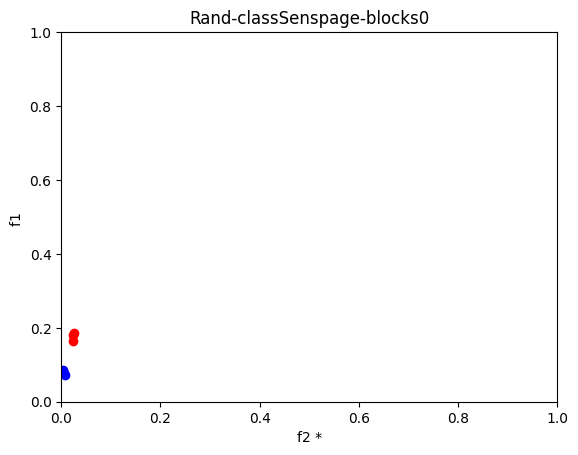

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMaxAcc'> on Bias-classSens-page-blocks0...


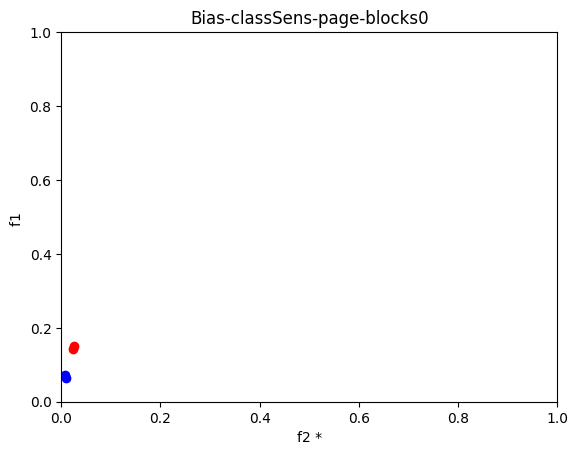

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMaxAcc'> on Rand-classSenspima...


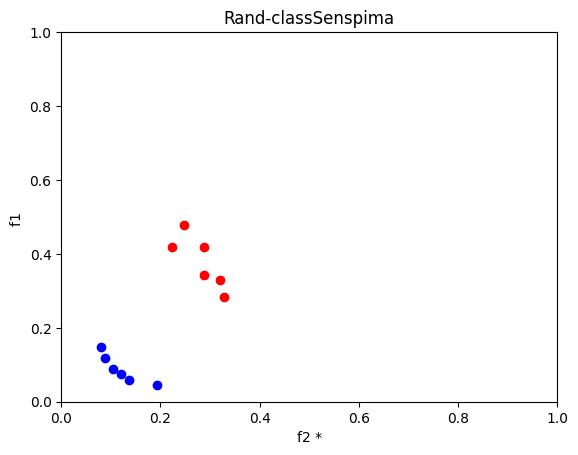

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMaxAcc'> on Bias-classSens-pima...


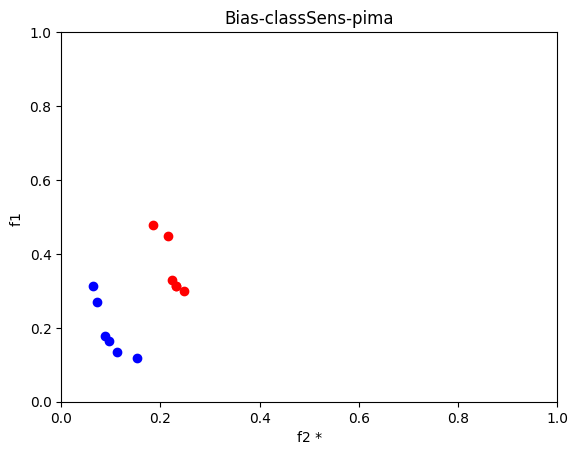

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMaxAcc'> on Rand-classSenssegment0...


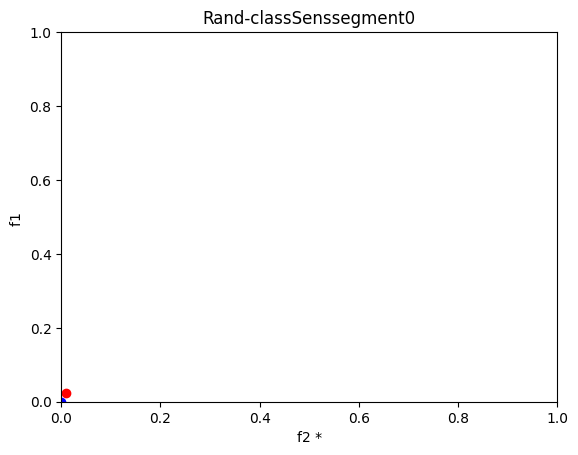

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMaxAcc'> on Bias-classSens-segment0...


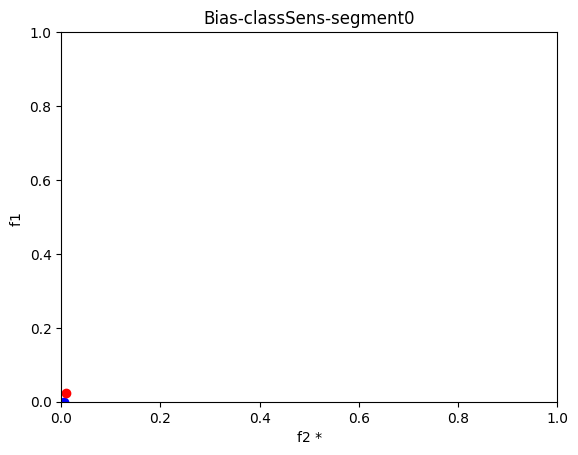

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMaxAcc'> on Rand-classSensvehicle0...


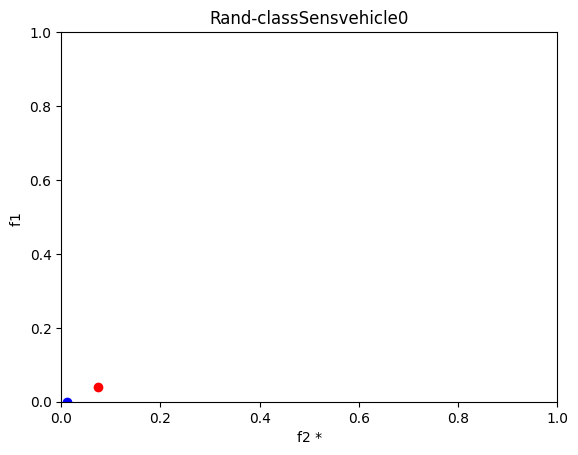

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMaxAcc'> on Bias-classSens-vehicle0...


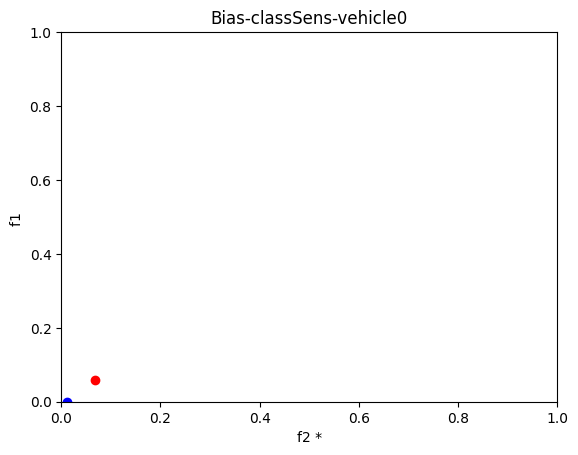

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMaxAcc'> on Rand-classSensyeast1...


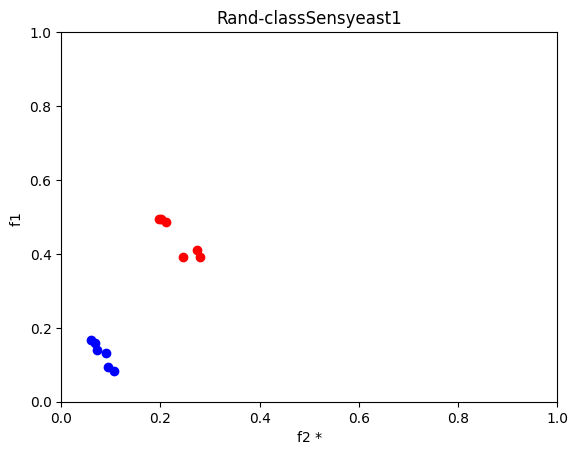

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMaxAcc'> on Bias-classSens-yeast1...


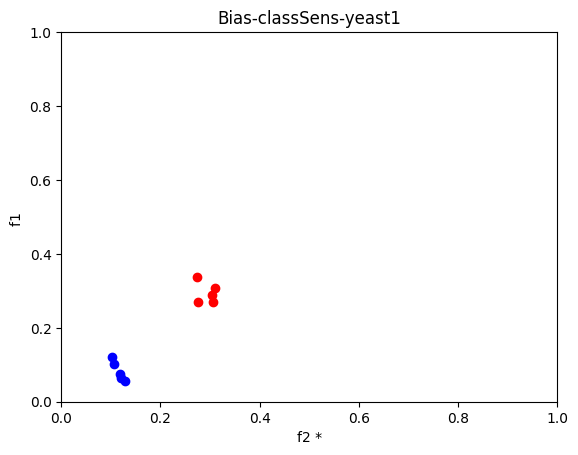

In [15]:
results = []
for X, y, X_train, X_val, X_test, y_train, y_val, y_test, name in datasets:
	result = execute_class_sensitive_optimization(
		X, y, X_train, X_val, X_test, y_train, y_val, y_test, 
		f"Rand-classSens{name}", 
		InstanceSelectionProblem_2_Obj_MinMaxAcc, 
		BinaryRandomSampling()
	)
	results.append(result)

	result = execute_class_sensitive_optimization(
		X, y, X_train, X_val, X_test, y_train, y_val, y_test, 
		f"Bias-classSens-{name}", 
		InstanceSelectionProblem_2_Obj_MinMaxAcc, 
		BiasedBinarySampling(y_train, 0.5, 0.7)
	)
	results.append(result)
	
	results.append(blank_row)
	# break
	

In [16]:
report_table_1(results)

,Label,Num Features,Num Examples,Training Size,Minority Class,-----,Baseline IR,Optimized IR
0,Rand-classSensglass1,9,214,145,1,--,1.8158,1.2759
1,Bias-classSens-glass1,9,214,145,1,--,1.8158,1.5862
2,---,---,---,---,---,--,---,---
3,Rand-classSenspage-blocks0,10,5472,3016,1,--,8.7889,4.362
4,Bias-classSens-page-blocks0,10,5472,3016,1,--,8.7889,3.2073
5,---,---,---,---,---,--,---,---
6,Rand-classSenspima,8,768,518,1,--,1.8657,1.1731
7,Bias-classSens-pima,8,768,518,1,--,1.8657,1.5982
8,---,---,---,---,---,--,---,---
9,Rand-classSenssegment0,19,2308,1319,1,--,6.0152,3.7786


In [17]:
report_table_2(results)

,Label,Base - Test Acc,Base - Test C0 Acc,Base - Test C1 Acc,-----,Optimized - Test Acc,Optimized - Test C0 Acc,Optimized - Test C1 Acc,Num Examples for Test Best,-----,Optimized - Val Acc,Optimized - Val C0 Acc,Optimized - Val C1 Acc,Num Examples for Val Best
0,Rand-classSensglass1,70.37,71.43,68.42,-----,74.07,85.71,52.63,71,-----,90.57,94.12,84.21,66
1,Bias-classSens-glass1,70.37,71.43,68.42,-----,75.93,88.57,52.63,83,-----,88.68,94.12,78.95,75
2,---,---,---,---,-----,---,---,---,---,-----,---,---,---,---
3,Rand-classSenspage-blocks0,96.93,98.05,87.05,-----,96.05,97.64,82.01,1507,-----,98.76,99.59,91.43,1496
4,Bias-classSens-page-blocks0,96.93,98.05,87.05,-----,96.35,97.56,85.61,1603,-----,98.61,99.27,92.86,1603
5,---,---,---,---,-----,---,---,---,---,-----,---,---,---,---
6,Rand-classSenspima,69.79,73.6,62.69,-----,70.83,77.6,58.21,237,-----,89.58,92.0,85.07,226
7,Bias-classSens-pima,69.79,73.6,62.69,-----,71.35,81.6,52.24,294,-----,84.9,93.6,68.66,291
8,---,---,---,---,-----,---,---,---,---,-----,---,---,---,---
9,Rand-classSenssegment0,98.61,98.59,98.78,-----,98.79,98.99,97.56,669,-----,100.0,100.0,100.0,669
